# Preprocessing

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
image_size = 28
epochs = 10
train_path = os.path.normpath("D:\Projects\DL\BCC\dataset\Train")
test_path = os.path.normpath("D:\Projects\DL\BCC\dataset\Test")
batch_size = 32
seed = 40
color_channel = 1

In [3]:
# Data stored in the form of tensors
train_ds = image_dataset_from_directory(
    train_path,
    labels = "inferred",
    label_mode = "int",
    validation_split = 0.2,
    subset = "training",
    seed = seed,
    image_size = (image_size,image_size),
    batch_size = batch_size,
)

val_ds = image_dataset_from_directory(
    train_path,
    labels = "inferred",
    label_mode = "int",
    validation_split = 0.2,
    subset = "validation",
    seed = seed,
    image_size = (image_size,image_size),
    batch_size = batch_size,
)

Found 2233 files belonging to 2 classes.
Using 1787 files for training.
Found 2233 files belonging to 2 classes.
Using 446 files for validation.


In [4]:
test_ds = image_dataset_from_directory(
    test_path,
    labels = "inferred",
    label_mode = "int",
    seed = seed,
    image_size = (image_size,image_size),
    batch_size = batch_size,
)

Found 638 files belonging to 2 classes.


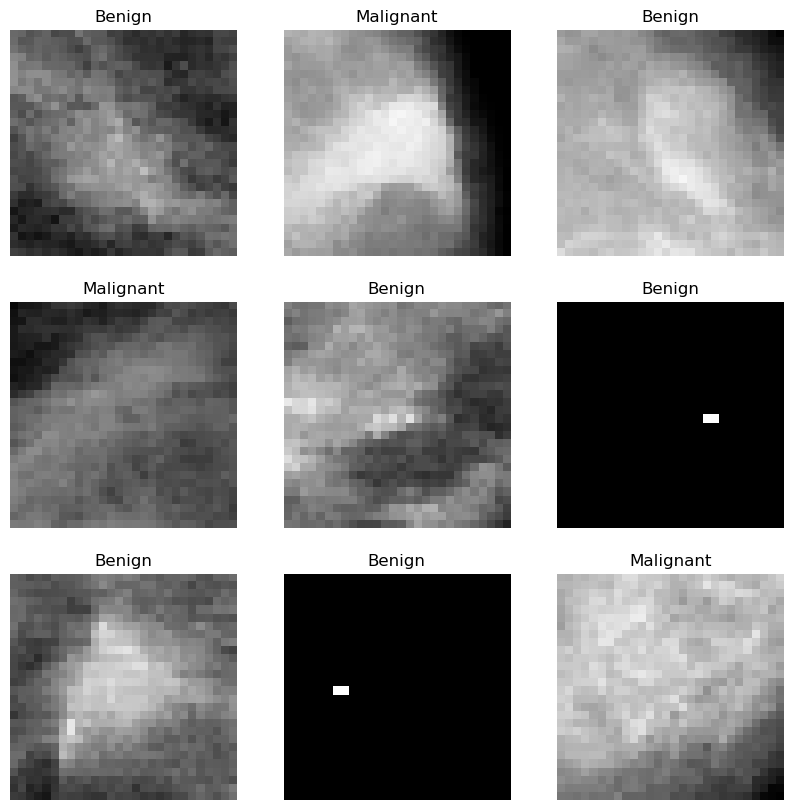

In [5]:
#kernel crashes when attempting to display some of the images using matplotlib in vscode
# Just for displaying some images with their labels
plt.figure(figsize = (10, 10))
class_names = train_ds.class_names
for images, labels in train_ds.take(1):
    class_labels = [class_names[label] for label in labels.numpy()]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_labels[i])
        plt.axis("off")

In [6]:
# convert the data to numpy form
train_images, train_labels, val_images, val_labels = [], [], [], []

for images, labels in train_ds:
    train_images.append(images)
    train_labels.append(labels)

train_images = np.vstack(train_images)
train_labels = np.concatenate(train_labels)

for images, labels in val_ds:
    val_images.append(images)
    val_labels.append(labels)

val_images = np.vstack(val_images)
val_labels = np.concatenate(val_labels)


In [7]:
test_images, test_labels = [], []

for images, labels in test_ds:
    test_images.append(images)
    test_labels.append(labels)

test_images = np.vstack(test_images)
test_labels = np.concatenate(test_labels)

In [8]:
print(train_labels.shape)
print(train_images.shape)

(1787,)
(1787, 28, 28, 3)


In [10]:
# Scaling the data as the images are black and white.
train_images = train_images/255.0
val_images = val_images/255.0

In [11]:
train_images[0]

array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)

In [9]:
# image_augmentation = ImageDataGenerator(
#     rotation_range = 40, # Randomly rotate up to 40 degrees
#     width_shift_range = 0.2, # Randomly shift width up to 20%
#     height_shift_range = 0.2, # Randomly shift width up to 20%
#     shear_range = 0.2, #shear transformations
#     zoom_range = 0.2, # zoom in or out up to 20%
#     horizontal_flip = True, # Randomly flip images horizontally
#     fill_mode = 'nearest', # how to fill in newly created pixels
#     featurewise_center = True,
#     featurewise_std_normalization = True,
# )

In [10]:
# image_augmentation.fit(train_images)

In [11]:
# train_augmented = image_augmentation.flow(
# train_images, train_labels, batch_size = batch_size)
# val_augmented = image_augmentation.flow(val_images, val_labels, batch_size = batch_size)

# Model

In [12]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.models import Model
from keras.layers import Conv2D, MaxPool2D, Dropout, Dense, Input, concatenate, GlobalAveragePooling2D, AveragePooling2D,Flatten
import keras_tuner as kt
from keras_tuner import RandomSearch

Using TensorFlow backend


In [35]:
# def model_builder(hp):
#   model = keras.Sequential()
#   model.add(keras.layers.Flatten(input_shape=(28, 28)))

#   # Tune the number of units in the first Dense layer
#   # Choose an optimal value between 32-512
#   hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
#   model.add(keras.layers.Dense(units=hp_units, activation='relu'))
#   model.add(keras.layers.Dense(10))

#   # Tune the learning rate for the optimizer
#   # Choose an optimal value from 0.01, 0.001, or 0.0001
#   hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

#   model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
#                 loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['accuracy'])

#   return model

In [13]:
def build_model(hp):
    #create model object
    model = keras.Sequential([
        #adding first convolutional layer
        keras.layers.Conv2D(
            #adding filter
            filters = hp.Int('conv_1_filter', min_value = 32, max_value= 128, step = 16),
            #adding filter size or kernel size
            kernel_size = hp.Choice('conv_1_kernel', values = [3,5]),
            #activation function
            activation = 'relu',
            input_shape = (28, 28, 3)
        ),
        # adding second convolution layer
        keras.layers.Conv2D(
            #adding filter
            filters = hp.Int('conv_2_filter', min_value = 32, max_value= 64, step = 16),
            #adding filter size or kernel size
            kernel_size = hp.Choice('conv_2_kernel', values = [3,5]),
            #activation function
            activation = 'relu'
        ),
        #adding flatten layer
        keras.layers.Flatten(),
        #adding dense layer
        keras.layers.Dense(
            units = hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
            activation = 'relu'
        ), 
        #output layer
        keras.layers.Dense(2, activation='softmax')
    ])
    
    #compilation of model
    model.compile(optimizer = keras.optimizers.Adam(hp.Choice('learning_rate', values = [1e-2, 1e-3])),
                loss = 'sparse_categorical_crossentropy',
                metrics = ['accuracy']
    )
    
    return model
    

In [14]:
# tuner = kt.Hyperband(model_builder,
#                      objective='val_accuracy',
#                      max_epochs=10,
#                      factor=3,
#                      directory='model_tuning',
#                      project_name='breast_cancer_classification')

In [15]:
tuner = RandomSearch(build_model, objective='val_accuracy', max_trials = 5)

In [16]:
tuner.search(train_images, train_labels, epochs = epochs, validation_data=(val_images, val_labels))

Trial 5 Complete [00h 00m 43s]
val_accuracy: 0.4708520174026489

Best val_accuracy So Far: 0.5291479825973511
Total elapsed time: 00h 03m 45s


In [17]:
# tuner.search(train_augmented, epochs=epochs, callbacks=[stop_early])

# # Get the optimal hyperparameters
# best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# print(f"""
# The hyperparameter search is complete. The optimal number of units in the first densely-connected
# layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
# is {best_hps.get('learning_rate')}.
# """)

In [18]:
model=tuner.get_best_models(num_models=1)[0]

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 112)       8512      
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 22, 48)        48432     
                                                                 
 flatten (Flatten)           (None, 23232)             0         
                                                                 
 dense (Dense)               (None, 96)                2230368   
                                                                 
 dense_1 (Dense)             (None, 2)                 194       
                                                                 
Total params: 2287506 (8.73 MB)
Trainable params: 2287506 (8.73 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.fit(test_images, test_labels, epochs = epochs)

Epoch 1/10
20/20 [==============================] - 2s 75ms/step - loss: 548.6255 - accuracy: 0.4624
Epoch 2/10
20/20 [==============================] - 2s 75ms/step - loss: 55.8294 - accuracy: 0.5470
Epoch 3/10
20/20 [==============================] - 2s 76ms/step - loss: 0.7054 - accuracy: 0.5768
Epoch 4/10
20/20 [==============================] - 2s 76ms/step - loss: 0.6767 - accuracy: 0.5878
Epoch 5/10
20/20 [==============================] - 2s 77ms/step - loss: 0.6719 - accuracy: 0.5893
Epoch 6/10
20/20 [==============================] - 1s 74ms/step - loss: 0.6712 - accuracy: 0.5893
Epoch 7/10
20/20 [==============================] - 1s 74ms/step - loss: 0.6700 - accuracy: 0.5893
Epoch 8/10
20/20 [==============================] - 2s 77ms/step - loss: 0.6696 - accuracy: 0.5893
Epoch 9/10
20/20 [==============================] - 2s 75ms/step - loss: 0.6687 - accuracy: 0.5893
Epoch 10/10
20/20 [==============================] - 2s 76ms/step - loss: 0.6683 - accuracy: 0.5909


In [21]:
loss, accuracy = model.evaluate(test_images, test_labels)

print(f"Test Loss: {loss*100}%")
print(f"Test Accuracy: {accuracy*100}%")

20/20 [==============================] - 0s 17ms/step - loss: 0.6679 - accuracy: 0.5909
Test Loss: 66.79359078407288%
Test Accuracy: 59.090906381607056%
